(4000.0, 11000.0, 4000.0, 11000.0)

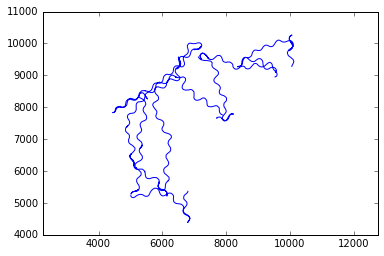

In [6]:
%matplotlib inline

import numpy as np
import numba

import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import animation

from IPython.display import HTML

from tierpsy_features.postures import get_eigen_projections, get_length
from tierpsy_features.curvatures import get_curvature_features, _h_curvature_grad
from tierpsy_features.velocities import _h_ax_range


data = np.load('./data/worm_example.npz')
skeletons = data['skeleton']
dorsal_contours = data['dorsal_contour']
ventral_contours = data['ventral_contour']

plt.plot(skeletons[:, 25, 0], skeletons[:, 25, 1])
plt.axis('equal')

(7505, 49, 2)
(7505, 49, 2)


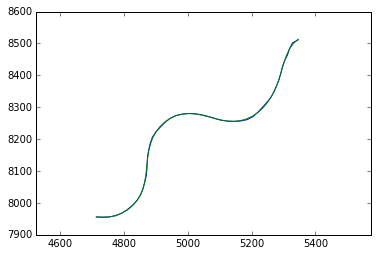

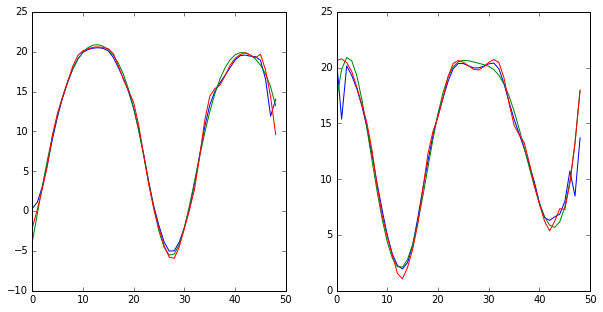

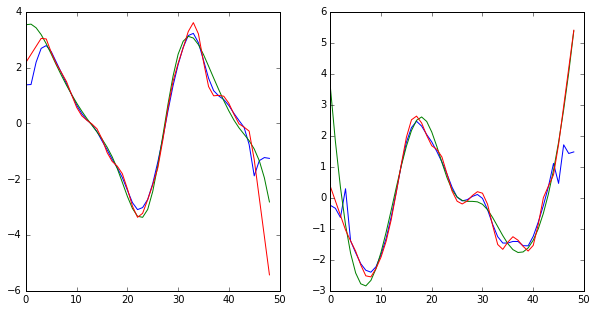

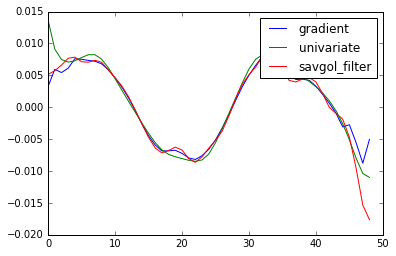

In [3]:
def curvature_fun(x_d, y_d, x_dd, y_dd):
    return (x_d*y_dd - y_d*x_dd)/(x_d*x_d + y_d*y_d)**1.5

from scipy.interpolate import UnivariateSpline, splrep, splev

#nn = 2272
nn = 6000
X = skeletons
skels = skeletons[nn]
x = skels[:, 0]
y = skels[:, 1]

# noise_n = 1/20
# nn = 1
# t = np.linspace(-np.pi, np.pi, 49)
# x = 5*np.cos(t) + np.random.rand(t.size)*noise_n
# y = 5*np.sin(t) + np.random.rand(t.size)*noise_n
# X = (np.vstack((x,y)).T)[None, ...]

def gradient_windowed(X, points_window):
    print(X.shape)
    w_s = 2*points_window
    right_side = np.pad(X[:, :-w_s, :], ((0,0), (w_s, 0), (0,0)), 'edge')
    left_side = np.pad(X[:, w_s:, :], ((0,0), (0, w_s), (0,0)), 'edge')

    ramp = np.full(X.shape[1] - w_s, w_s*2)
    ramp = np.pad(ramp, 
                    pad_width = (points_window, points_window), 
                    mode='linear_ramp',  
                    end_values = w_s
                    )
    grad = (left_side - right_side) / ramp[None, :, None]
    
    return grad


points_window = 1
d = gradient_windowed(X, points_window)
dd = gradient_windowed(d, points_window)

gx = d[nn, :, 0]
gy = d[nn, :, 1]

ggx = dd[nn, :, 0]
ggy = dd[nn, :, 1]

# gx = np.gradient(x, edge_order=2)
# gy = np.gradient(y, edge_order=2)
# ggx = np.gradient(gx, edge_order=2)
# ggy = np.gradient(gy, edge_order=2)

curvature_g = curvature_fun(gx, gy, ggx, ggy)

n = np.arange(x.size)
fx = UnivariateSpline(n, x, k=5)
fy = UnivariateSpline(n, y, k=5)
x_d = fx.derivative(1)(n)
x_dd = fx.derivative(2)(n)
y_d = fy.derivative(1)(n)
y_dd = fy.derivative(2)(n)
curvature_u = curvature_fun(x_d, y_d, x_dd, y_dd)

from scipy.signal import savgol_filter
dx = savgol_filter(x, window_length=7, polyorder=3, deriv=1)
dy = savgol_filter(y, window_length=7, polyorder=3, deriv=1)
ddx = savgol_filter(x, window_length=7, polyorder=3, deriv=2)
ddy = savgol_filter(y, window_length=7, polyorder=3, deriv=2)
curvature_s = curvature_fun(dx, dy, ddx, ddy)

offset = np.arange(curvature_g.size)

plt.figure()
plt.plot(x, y)
plt.plot(fx(n), fy(n))
plt.axis('equal')

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(offset, gy)
plt.plot(y_d)
plt.plot(dy)

plt.subplot(1,2,2)
plt.plot(offset, gx)
plt.plot(x_d)
plt.plot(dx)

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(offset, ggy)
plt.plot(y_dd)
plt.plot(ddy)

plt.subplot(1,2,2)
plt.plot(offset, ggx)
plt.plot(x_dd)
plt.plot(ddx)

plt.figure()
plt.plot(offset, curvature_g, label='gradient')
plt.plot(curvature_u, label='univariate')
plt.plot( curvature_s, label='savgol_filter')
plt.legend()





angle
Index(['curvature_head', 'curvature_hips', 'curvature_midbody',
       'curvature_neck', 'curvature_tail'],
      dtype='object')
spline
Index(['curvature_head', 'curvature_hips', 'curvature_midbody',
       'curvature_neck', 'curvature_tail'],
      dtype='object')
savgol
Index(['curvature_head', 'curvature_hips', 'curvature_midbody',
       'curvature_neck', 'curvature_tail'],
      dtype='object')
grad
Index(['curvature_head', 'curvature_hips', 'curvature_midbody',
       'curvature_neck', 'curvature_tail'],
      dtype='object')


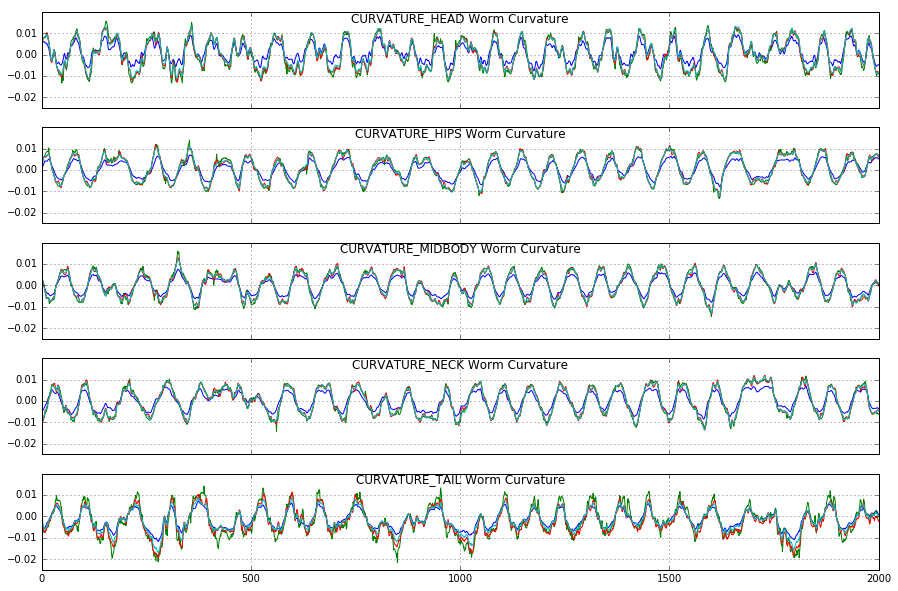

In [4]:
d_r = (3500, 5500)

f, axs = plt.subplots(5, sharex=True, sharey=True, figsize = (15, 10))

for method in ['angle', 'spline', 'savgol', 'grad']:
    print(method)
    segment_curvatures = \
    get_curvature_features(skeletons[d_r[0]:d_r[1]+1], method = method)

    print(segment_curvatures.keys())
    for ax, (p, curv) in zip(axs, segment_curvatures.items()):  
        ax.plot(curv)
        ax.set_title(p.upper() + ' Worm Curvature', y=0.85)
        ax.grid('on')
    #plt.xlim(d_r)

In [4]:
np.nanargmax(np.abs(segment_curvatures))
segment_curvatures

,curvature_head,curvature_hips,curvature_midbody,curvature_neck,curvature_tail
0,0.005271,0.002481,0.003764,-0.007272,-0.002451
1,0.005887,0.002963,0.002805,-0.008144,-0.002675
2,0.006482,0.003566,0.001827,-0.008716,-0.003141
3,0.007151,0.004431,0.001085,-0.008628,-0.004128
4,0.007702,0.005131,0.000638,-0.008159,-0.004556
5,0.007991,0.005797,0.000049,-0.007362,-0.005011
6,0.008133,0.006177,-0.000950,-0.006714,-0.005545
7,0.008372,0.006550,-0.001786,-0.005974,-0.005892
8,0.008327,0.006601,-0.002568,-0.005213,-0.005972
9,0.008611,0.006551,-0.003387,-0.004700,-0.005678


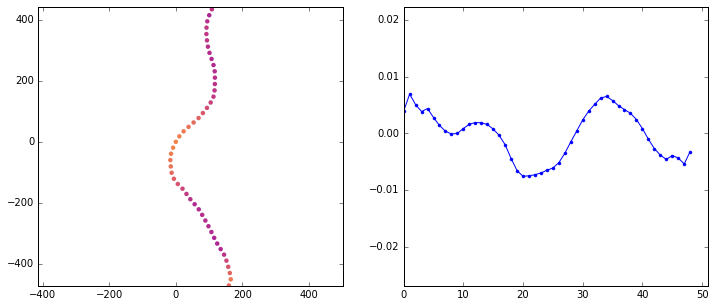

In [14]:
curvatures = _h_curvature_grad(skeletons)

ini_t = d_r[0]
fin_t = d_r[0]+500#d_r[1]

skel_a = skeletons[ini_t:fin_t]
skel_a = skel_a - skel_a[:, 25, :][:, None, :]
angs = curvatures[ini_t:fin_t]

x_angles = np.arange(angs.shape[1])

x_range, y_range = _h_ax_range(skel_a)
fig = plt.figure(figsize = (12, 5))
ax_skels = plt.subplot(1,2,1)

ax_bends = plt.subplot(1,2,2)
l_bends, = ax_bends.plot([], [], '.-')
ax_bends.set_xlim(0, angs.shape[1] + 2*points_window)

curv_range = (np.nanmin(curvatures[3:-3]), np.nanmax(curvatures[3:-3]))
ax_bends.set_ylim(curv_range)

#animation function. This is called sequentially
def _animate(i):
    x = skel_a[i, :, 0]
    y = skel_a[i, :, 1]
    curv = curvatures[i]
    /
    curv_n = (curv-curv_range[0])/(curv_range[1] - curv_range[0])
    curv_n = np.clip(curv_n, 0, 1)
    c = cm.plasma(curv_n)
    
    ax_skels.clear()
    ax_skels.scatter(x, y, c=c, edgecolors='none')
    ax_skels.set_xlim(*x_range)
    ax_skels.set_ylim(*y_range)
    
    l_bends.set_data(x_angles, angs[i])
    return l_bends,


# call the animator. blit=True means only re-draw the parts that have changed.
tot = skel_a.shape[0]
anim = animation.FuncAnimation(fig, 
                               _animate,
                               interval=50, 
                               frames = tot,
                               blit=True);
HTML(anim.to_html5_video())

(7505, 41)
(7505, 49)


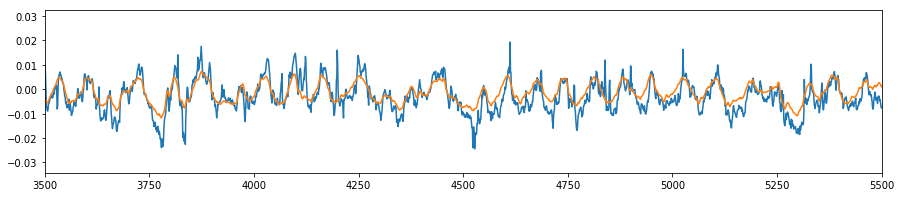

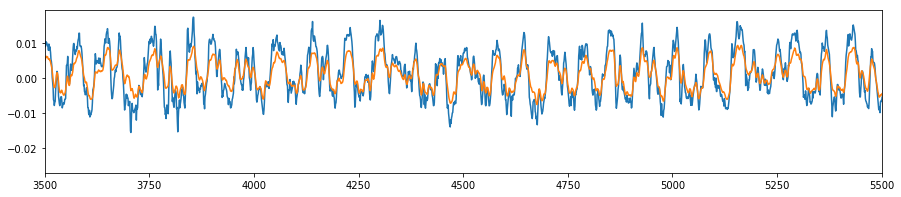

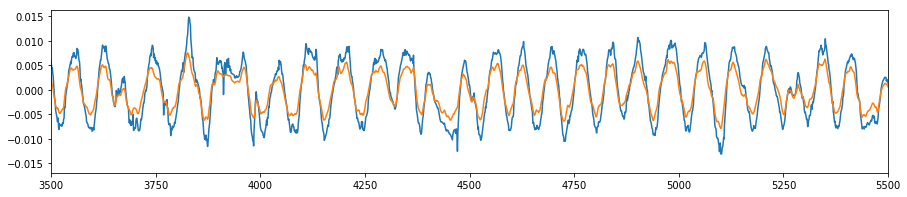

In [4]:
curvatures_fit = _h_curvature_test(skeletons)

xlim = d_r

nn = points_window-1
mid = int(curvatures.shape[1]/2)

plt.figure(figsize = (15, 3))
plt.plot(curvatures_fit[:, -nn])
plt.plot(curvatures[:, -1]) 
plt.xlim(xlim)

plt.figure(figsize = (15, 3))
plt.plot(curvatures_fit[:, nn])
plt.plot(curvatures[:, 0]) 
plt.xlim(xlim)

plt.figure(figsize = (15, 3))
plt.plot(curvatures_fit[:, 25])
plt.plot(curvatures[:, mid]) 
plt.xlim(xlim)

print(curvatures.shape)
print(curvatures_fit.shape)

(41,)
(49,)


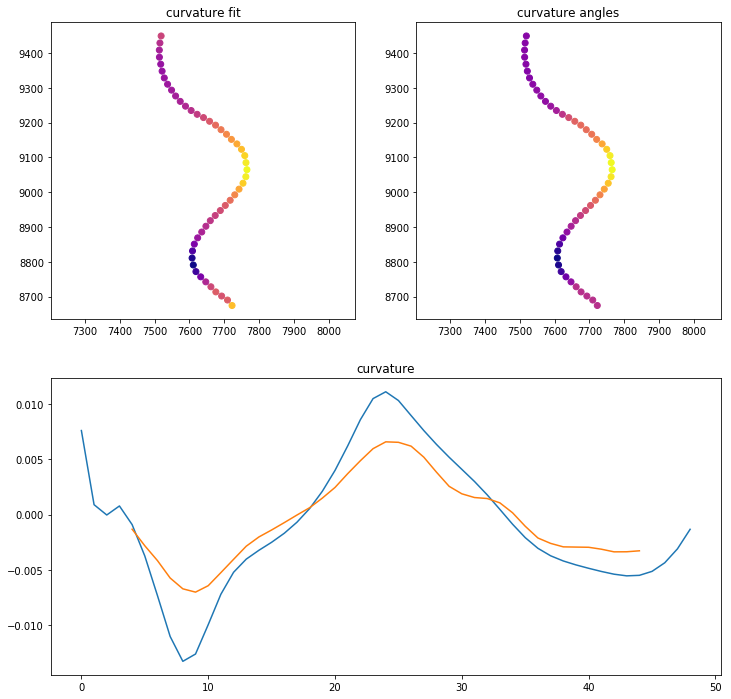

In [5]:
t = 2340
skel = skeletons[t]
curv_f = curvatures_fit[t]
curv = curvatures[t]

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
x = skel[:, 0]
y = skel[:, 1]
curv_range = (np.nanmin(curv_f), np.nanmax(curv_f))
curv_n = (curv_f - curv_range[0])/(curv_range[1] - curv_range[0])
c = cm.plasma(curv_n)
plt.scatter(x, y, c=c)
plt.title('curvature fit')
plt.axis('equal')

plt.subplot(2,2,2)
x = skel[:, 0]
y = skel[:, 1]
curv_range = (np.nanmin(curv), np.nanmax(curv))
curv_n = (curv - curv_range[0])/(curv_range[1] - curv_range[0])
curv_n = np.pad(curv_n, (points_window,points_window), 'edge')
c = cm.plasma(curv_n)
plt.scatter(x, y, c=c)
plt.title('curvature angles')
plt.axis('equal')

plt.subplot(2,1,2)
plt.plot(curv_f)
plt.plot(np.arange(curv.size) + points_window, curv)
plt.title('curvature')

print(curv.shape)
print(curv_f.shape)



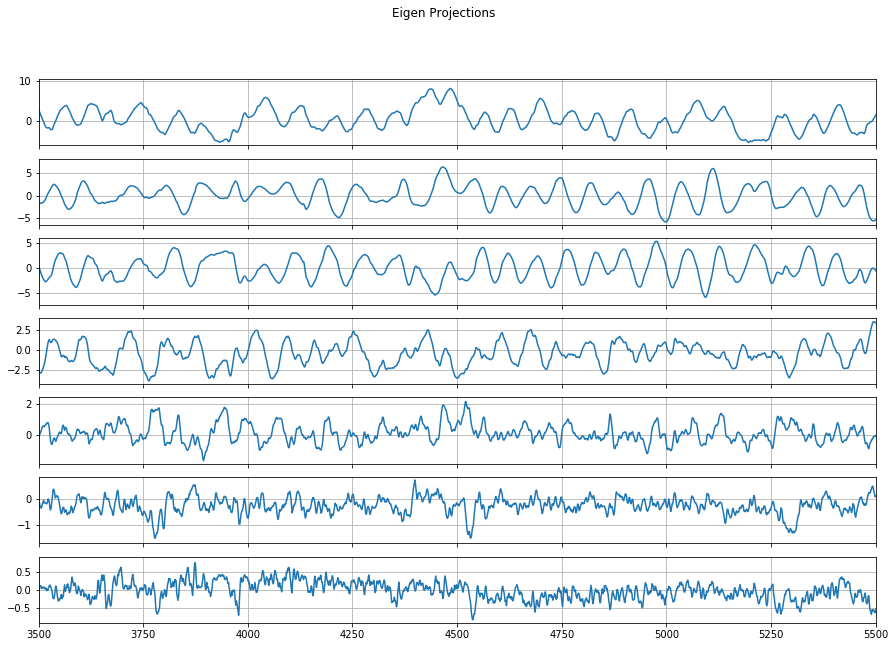

In [6]:
eigen_projections = get_eigen_projections(skeletons)


xlim = d_r

f, axs = plt.subplots(eigen_projections.shape[1], sharex=True, figsize = (15, 10))

for ii, ax in enumerate(axs):  
    ax.plot(eigen_projections[:, ii])
    ax.grid('on')
plt.xlim(xlim)
plt.suptitle('Eigen Projections')

(4543.9765976656072, 7708.7699267804464, 4535.605923678947, 10445.830384576579)

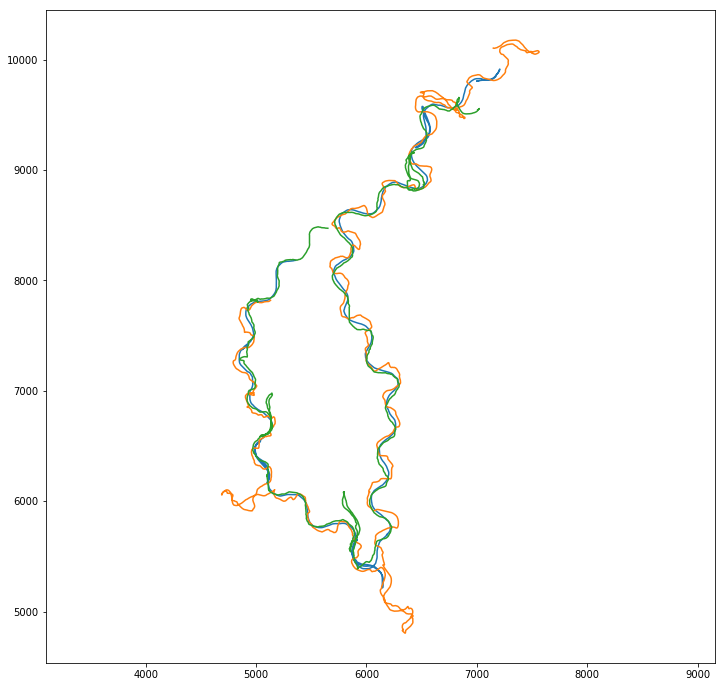

In [7]:
tt = np.arange(d_r[0], d_r[1])

ext_ind = 1

plt.figure(figsize=(12,12))
plt.plot(skeletons[tt, 25, 0], skeletons[tt, 25, 1])
plt.plot(skeletons[tt, ext_ind-1, 0], skeletons[tt, ext_ind-1, 1])
plt.plot(skeletons[tt, -ext_ind, 0], skeletons[tt, -ext_ind, 1])
plt.axis('equal')